In [1]:
import numpy as np
from numpy import linalg as la
import networkx as nx
import matplotlib.pyplot as plt
import time
import dgl
import torch
from torch import nn
from torch.nn import functional as F

import src.dag_utils as dag_utils
from src.arch import DAGConv, SF_DAGConv, FB_DAGConv
from src.models import Model, AlternatingModel
from src.baselines_archs import GCNN_2L

SEED = 10
np.random.seed(SEED)
torch.manual_seed(SEED)
dgl.random.seed(SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


DAG created
Inverted: 0.009103536605834961
Dq obtained: 0.23711395263671875
GSO computed: 0.1134178638458252


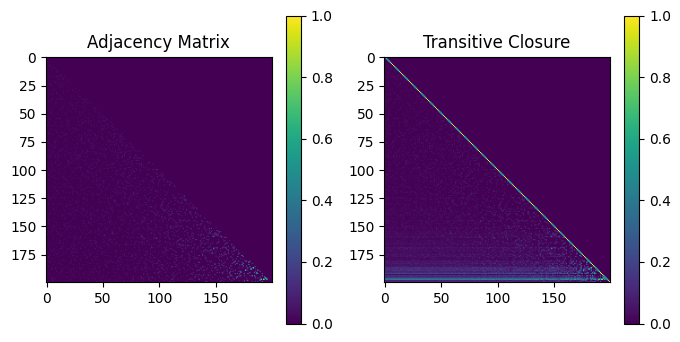

In [2]:
# Create graph
p = .2
N = 200

Adj, dag = dag_utils.create_dag(N, p)

print("DAG created")

t_i = time.time()
W = la.inv(np.eye(N) - Adj)
W_inf = la.inv(W)
print('Inverted:', time.time()-t_i)

t_i = time.time()
Dq_list = [dag_utils.compute_Dq(dag, i, N) for i in range(N)]
print('Dq obtained:', time.time()-t_i)

t_i = time.time()
GSOs = np.array([(W * Dq_list[i]) @ W_inf for i in range(N)])
print('GSO computed:', time.time()-t_i)

# Plot graph
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im1 = axs[0].imshow(Adj, cmap='viridis')
axs[0].set_title('Adjacency Matrix')
im2 = axs[1].imshow(W, cmap='viridis')
axs[1].set_title('Transitive Closure')
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])


# Example 1: modeling diffusion

In [3]:
def inspect_data(X_data, Y_data):
    print('Summary for X_data:')
    for key, value in X_data.items():
        norm = la.norm(value, 2, axis=1).mean()
        print(f'\t{key}: size: {value.shape}  -  norm: {norm:.3f}')

    print('Summary for Y_data:')
    for key, value in Y_data.items():
        norm = la.norm(value, 2, axis=1).mean()
        print(f'\t{key}: size: {value.shape}  -  norm: {norm:.3f}')

In [4]:
# Create DATA
M = 2000
M_train = int(.7*M)
M_val = int(.2*M)
M_test = int(.1*M)
max_src_node = 25  # 5
n_sources = 5
n_p = .1
max_GSO = 100
min_GSO = 50
n_GSOs = 25

range_GSO = np.arange(min_GSO, max_GSO)
gsos_idx = np.random.choice(range_GSO, size=n_GSOs, replace=False)
sel_GSOs = GSOs[gsos_idx]
Y, X = dag_utils.create_diff_data(M, sel_GSOs, max_src_node, n_p, n_sources, src_t='random',
                                  norm_y='l2_norm', norm_f_coefs=False, ftype='normal')


X_t = torch.Tensor(X)
Y_t = torch.Tensor(Y)

X_data = {'train': X_t[:M_train], 'val': X_t[M_train:-M_test], 'test': X_t[-M_test:]}
Y_data = {'train': Y_t[:M_train], 'val': Y_t[M_train:-M_test], 'test': Y_t[-M_test:]}


Summary for X_data:
	train: size: torch.Size([1400, 200, 1])  -  norm: 2.216
	val: size: torch.Size([400, 200, 1])  -  norm: 2.219
	test: size: torch.Size([200, 200, 1])  -  norm: 2.193
Summary for Y_data:
	train: size: torch.Size([1400, 200, 1])  -  norm: 1.007
	val: size: torch.Size([400, 200, 1])  -  norm: 1.008
	test: size: torch.Size([200, 200, 1])  -  norm: 1.007


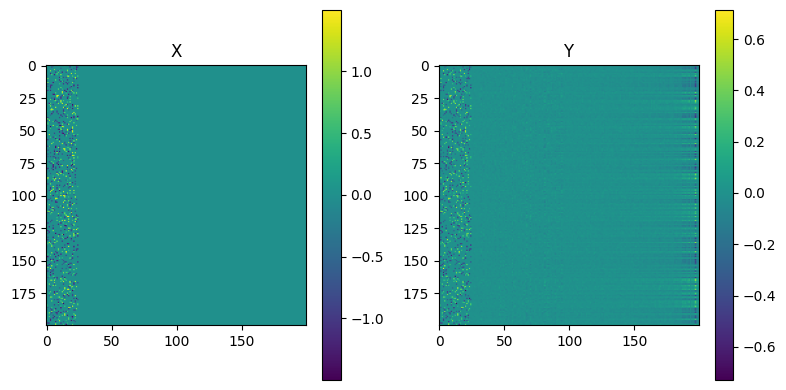

In [5]:
inspect_data(X_data, Y_data)

# Plot some data
fig, axes = plt.subplots(1, 2, figsize=(8,4))
img1  = axes[0].imshow(X[:N], cmap='viridis')
axes[0].set_title('X')
cbar1 = fig.colorbar(img1, ax=axes[0])
img2 = axes[1].imshow(Y[:N], cmap='viridis')
axes[1].set_title('Y')
cbar2 = fig.colorbar(img2, ax=axes[1])
plt.tight_layout()

In [6]:
# Create DAGConv model
in_dim = X.shape[2]
hid_dim = 64
out_dim = Y.shape[2]
L = 2  # 2
l_act = None #nn.Sigmoid()
n_rand_GSOs = 5
loss = nn.MSELoss(reduction='mean')

X_train = torch.Tensor(X_data['train']).to(device)

# Training params
eval_freq = 1
batch_size = 25
lr = 5e-4 #1e-3
epochs = 25
patience = 10
wd = 1e-4
bias = True
verbose = True
errs = {}
results = {}
times = {}
GSOs_tensor = torch.Tensor(GSOs)
sel_GSOs = GSOs_tensor[gsos_idx]
rnd_idx = np.random.choice(N, size=n_rand_GSOs, replace=False)
print('rand:', rnd_idx)
print('true:', gsos_idx)
rnd_sel_GSO = GSOs_tensor[rnd_idx]


##############   DAGCNN   ##############
print('DAGCNN')
arch = DAGConv(in_dim, hid_dim, out_dim, L, GSOs_tensor, last_act=l_act).to(device)
model = Model(arch, loss, device=device)
t_i = time.time()
losses = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                       patience=patience, verb=True)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['DAG'] = model.test(X_data['test'], Y_data['test'])
results['DAG'] = losses
times['DAG'] = t_e
###########################################


##########   DAGCNN - Sel GSOs   ##########
print('DAGCNN WITH SELECTED GSOs')
arch = DAGConv(in_dim, hid_dim, out_dim, L, sel_GSOs, last_act=l_act, bias=bias).to(device)
model = Model(arch, loss, device=device)
t_i = time.time()
losses = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                             patience=patience, verb=verbose)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['DAG-Prior'] = model.test(X_data['test'], Y_data['test'])
results['DAG-Prior'] = losses
times['DAG-Prior'] = t_e
#############################################


##########   DAGCNN - Rand GSOs   ##########
print('DAGCNN Random GSOs')
arch = DAGConv(in_dim, hid_dim, out_dim, L, rnd_sel_GSO, last_act=l_act, bias=bias).to(device)
model = Model(arch, loss, device=device)
t_i = time.time()
losses = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                             patience=patience, verb=verbose)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['DAG-Rand'] = model.test(X_data['test'], Y_data['test'])
results['DAG-Rand'] = losses
times['DAG-Rand'] = t_e
#############################################


# print('Alt DAGCNN WITH SELECTED GSOs')
# sel_GSOs = GSOs_tensor[gsos_idx]
# arch_alt = DAGConv(in_dim, hid_dim, out_dim, L, sel_GSOs, last_act=l_act, bias=bias).to(device)
# model = AlternatingModel(arch_alt, loss, 1, 1, device=device)
# t_i = time.time()
# losses_dag_prior = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=eval_freq,
#                              patience=patience, verb=verbose)
# t_e = time.time() - t_i
# print('\tTime:', t_e)
# errs['Alt-DAG-Prior'] = model.test(X_data['test'], Y_data['test'])
# results['Alt-DAG-Prior'] = losses_dag_prior
# times['Alt-DAG-Prior'] = t_e


# print('SF-DAGCNN')
# arch_sf = SF_DAGConv(in_dim, out_dim, L, GSOs_tensor, last_act=l_act).to(device)
# model = Model(arch_sf, loss, device=device)
# t_i = time.time()
# losses_dag = model.fit(X_data, Y_data, lr, epochs*10, batch_size, wd, eval_freq=eval_freq,
#                        patience=patience, verb=verbose)
# t_e = time.time() - t_i
# print('\tTime:', t_e)
# errs['SF-DAG-Prior'] = model.test(X_data['test'], Y_data['test'])
# results['SF-DAG-Prior'] = losses_dag
# times['SF-DAG-Prior'] = t_e


# print('SF-DAGCNN WITH SELECTED GSOs')
# arch_sf = SF_DAGConv(in_dim, out_dim, L, sel_GSOs, last_act=l_act).to(device)
# model = Model(arch_sf, loss, device=device)
# t_i = time.time()
# losses_dag = model.fit(X_data, Y_data, lr, epochs*10, batch_size, wd, eval_freq=eval_freq,
#                        patience=patience, verb=verbose)
# t_e = time.time() - t_i
# print('\tTime:', t_e)
# errs['SF-DAG'] = model.test(X_data['test'], Y_data['test'])
# results['SF-DAG'] = losses_dag
# times['SF-DAG'] = t_e

##############   FB-DAGCNN   ##############
print('FB-DAGCNN')
arch = FB_DAGConv(in_dim, hid_dim, out_dim, L, GSOs_tensor, last_act=l_act).to(device)
model = Model(arch, loss, device=device)
t_i = time.time()
losses_dag = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                       patience=patience, verb=verbose)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['FB-DAG'] = model.test(X_data['test'], Y_data['test'])
results['FB-DAG'] = losses_dag
times['FB-DAG'] = t_e
#############################################


##########   FB-DAGCNN - Sel GSOS   ##########
print('FB-DAGCNN WITH SELECTED GSOs')
arch = FB_DAGConv(in_dim, hid_dim, out_dim, L, sel_GSOs, last_act=l_act).to(device)
model = Model(arch, loss, device=device)
t_i = time.time()
losses_dag = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                       patience=patience, verb=verbose)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['FB-DAG-Prior'] = model.test(X_data['test'], Y_data['test'])
results['FB-DAG-Prior'] = losses_dag
times['FB-DAG-Prior'] = t_e


##########   FB-DAGCNN - Rand GSOs   ##########
print('FB-DAGCNN Random GSOs')
arch = FB_DAGConv(in_dim, hid_dim, out_dim, L, rnd_sel_GSO, last_act=l_act, bias=bias).to(device)
model = Model(arch, loss, device=device)
t_i = time.time()
losses = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=eval_freq,
                             patience=patience, verb=verbose)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['FB-DAG-Rand'] = model.test(X_data['test'], Y_data['test'])
results['FB-DAG-Rand'] = losses
times['FB-DAG-Rand'] = t_e
###############################################


#################   GNN - A   #################
print('CLASSICAL GNN using A')
S = dgl.from_networkx(nx.from_numpy_array(Adj.T)).add_self_loop().to(device)
arch = GCNN_2L(in_dim, hid_dim, out_dim, S)
model = Model(arch, loss, device=device)
t_i = time.time()
losses_gnnA = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=1,
                        patience=patience, verb=verbose)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['GNN-A'] = model.test(X_data['test'], Y_data['test'])
results['GNN-A'] = losses_gnnA
times['GNN-A'] = t_e
###############################################


################   GNN - GSO   ################
print('CLASSICAL GNN using GSO')
S = dgl.from_networkx(nx.from_numpy_array(rnd_sel_GSO[0].numpy())).add_self_loop().to(device)
arch = GCNN_2L(in_dim, hid_dim, out_dim, S)
model = Model(arch, loss, device=device)
t_i = time.time()
losses_gnnA = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=1,
                        patience=patience, verb=verbose)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['GNN-GSO'] = model.test(X_data['test'], Y_data['test'])
results['GNN-GSO'] = losses_gnnA
times['GNN-GSO'] = t_e
###############################################


################   GNN - GSO   ################
print('CLASSICAL GNN using A')
S = dgl.from_networkx(nx.from_numpy_array(rnd_sel_GSO[0].T.numpy())).add_self_loop().to(device)
arch = GCNN_2L(in_dim, hid_dim, out_dim, S)
model = Model(arch, loss, device=device)
t_i = time.time()
losses_gnnA = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=1,
                        patience=patience, verb=verbose)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['GNN-GSOT'] = model.test(X_data['test'], Y_data['test'])
results['GNN-GSOT'] = losses_gnnA
times['GNN-GSOT'] = t_e
###############################################


#################   GNN - W   #################
print('CLASSICAL GNN using W')
S = dgl.from_networkx(nx.from_numpy_array(W.T)).add_self_loop().to(device)
arch = GCNN_2L(in_dim, hid_dim, out_dim, S)
model = Model(arch, loss, device=device)
t_i = time.time()
losses_gnnW = model.fit(X_data, Y_data, lr, epochs, batch_size, wd, eval_freq=1,
                        patience=patience, verb=verbose)
t_e = time.time() - t_i
print('\tTime:', t_e)
errs['GNN-W'] = model.test(X_data['test'], Y_data['test'])
results['GNN-W'] = losses_gnnW
times['GNN-W'] = t_e
###############################################

rand: [ 25 159 199 139 131]
true: [86 96 76 68 74 97 89 64 78 92 51 82 88 75 73 53 61 90 83 60 52 55 56 94
 58]
DAGCNN
Epoch 1/25 - Loss Train: 0.124937 - Val Loss: 0.146890
Epoch 2/25 - Loss Train: 0.017629 - Val Loss: 0.020420
Epoch 3/25 - Loss Train: 0.003535 - Val Loss: 0.004027
Epoch 4/25 - Loss Train: 0.001271 - Val Loss: 0.001307
Epoch 5/25 - Loss Train: 0.001299 - Val Loss: 0.001149
Epoch 6/25 - Loss Train: 0.001295 - Val Loss: 0.001126
Epoch 7/25 - Loss Train: 0.001262 - Val Loss: 0.001118
Epoch 8/25 - Loss Train: 0.001212 - Val Loss: 0.001133
Epoch 9/25 - Loss Train: 0.001162 - Val Loss: 0.001174
Epoch 10/25 - Loss Train: 0.001132 - Val Loss: 0.001219
Epoch 11/25 - Loss Train: 0.001125 - Val Loss: 0.001229
Epoch 12/25 - Loss Train: 0.001123 - Val Loss: 0.001216
Epoch 13/25 - Loss Train: 0.001121 - Val Loss: 0.001203
Epoch 14/25 - Loss Train: 0.001120 - Val Loss: 0.001200
Epoch 15/25 - Loss Train: 0.001119 - Val Loss: 0.001205
Epoch 16/25 - Loss Train: 0.001121 - Val Loss: 0.0

Naive error: 2.47439588908647
- DAG: Mean err: 0.234 Std: 0.315 Time: 26.16
- DAG-Prior: Mean err: 0.218 Std: 0.356 Time: 5.09
- DAG-Rand: Mean err: 0.207 Std: 0.258 Time: 1.89
- FB-DAG: Mean err: 0.074 Std: 0.054 Time: 29.55
- FB-DAG-Prior: Mean err: 0.067 Std: 0.056 Time: 3.95
- FB-DAG-Rand: Mean err: 0.206 Std: 0.280 Time: 2.11
- GNN-A: Mean err: 0.827 Std: 0.085 Time: 3.27
- GNN-GSO: Mean err: 0.969 Std: 0.027 Time: 1.72
- GNN-GSOT: Mean err: 0.969 Std: 0.026 Time: 3.32
- GNN-W: Mean err: 0.948 Std: 0.057 Time: 2.79


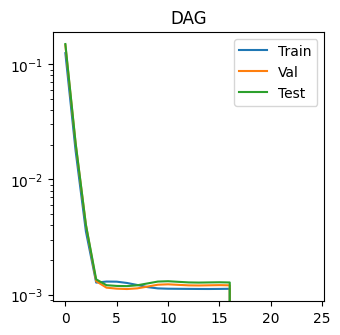

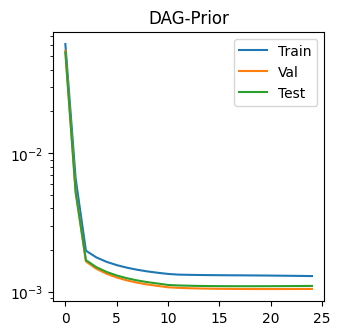

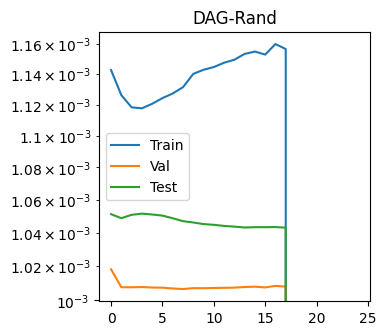

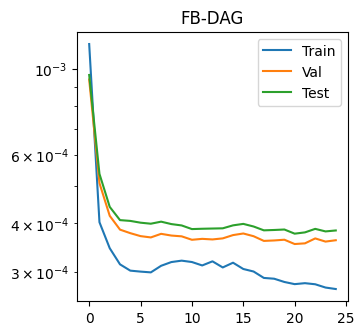

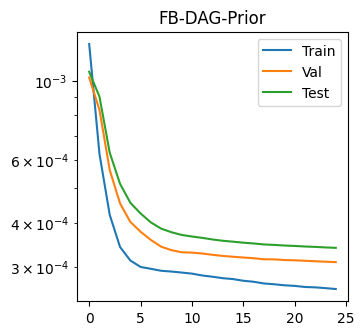

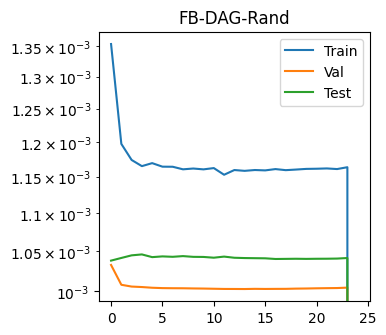

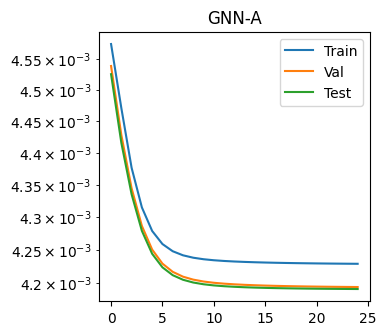

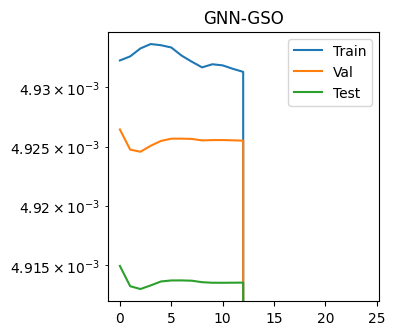

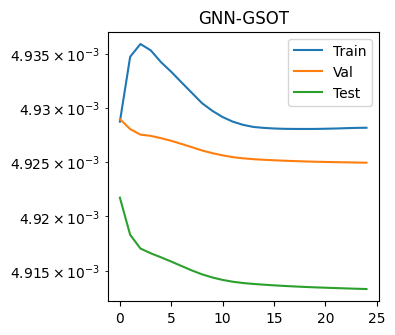

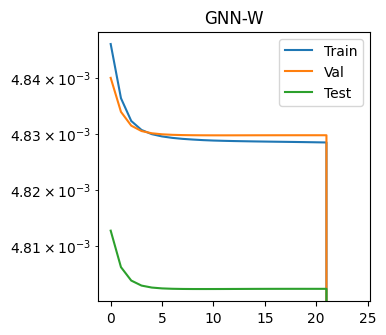

In [7]:
naive_err = (la.norm(Y-X, 2, axis=1, keepdims=True)/la.norm(Y, 2, axis=1, keepdims=True))**2
naive_err = naive_err.mean()

print('Naive error:', naive_err)
for key, value in errs.items():
    print(f'- {key}: Mean err: {value[0]:.3f} Std: {value[1]:.3f} Time: {times[key]:.2f}')

for key, value in results.items():
    plt.figure(figsize=(3.5, 3.5))
    plt.semilogy(value['train'], label='Train')
    plt.semilogy(value['val'], label='Val')
    plt.semilogy(value['test'], label='Test')
    plt.legend()
    plt.title(f'{key}')


In [8]:
# Define the number of samples you want to draw
interval1 = (-2, -1)
interval2 = (1, 2)
num_samples = 50

# Generate random samples from each interval
samples_interval1 = np.random.uniform(interval1[0], interval1[1], (num_samples,3))
samples_interval2 = np.random.uniform(interval2[0], interval2[1], (num_samples, 3))

# Concatenate the samples
all_samples = np.concatenate((samples_interval1, samples_interval2)).reshape(100*3)
print(all_samples.shape)
# Shuffle the samples (if needed)
np.random.shuffle(all_samples)
all_samples = all_samples.reshape([100,3])

# Print the first few samples as an example
print(all_samples[:10])

(300,)
[[ 1.91275581 -1.03922305 -1.23334353]
 [ 1.04265636  1.00900744  1.03169883]
 [-1.33116154 -1.40297111 -1.8365376 ]
 [ 1.74276687 -1.66622561  1.12553831]
 [-1.6523294  -1.30555287 -1.24060385]
 [ 1.26700415 -1.43939983  1.14683909]
 [ 1.24012796  1.84263275 -1.20949648]
 [-1.21847049 -1.16161028 -1.64706274]
 [-1.05203224  1.60994305 -1.43072683]
 [-1.12076983 -1.10285866 -1.74885357]]


# Example 2: source identification